In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters
DECK_SIZE = 52
HAND_SIZE = 13
N_TRIALS = 10000

In [3]:
# Calculate largest gap in circular array
def calc_largest_gap(slots, n_slots):
    # Sort the chosen slots
    slots_sorted = np.sort(slots)
    # Calculate gaps between consecutive slots
    gaps = np.diff(slots_sorted, append=slots_sorted[0] + n_slots)
    return np.max(gaps)

In [4]:
# Calculate gaps at both ends of linear array
def calc_end_gaps(slots, n_slots):
    # Sort the chosen slots
    slots_sorted = np.sort(slots)
    # Calculate gaps for both ends
    lower_end_gap = slots_sorted[0]
    upper_end_gap = n_slots - slots_sorted[-1]
    # Calculate gaps at both ends
    return lower_end_gap + upper_end_gap

In [5]:
# Find min and max in wrapped array
def reorder_hand(slots, n_slots):
    # Sort the chosen slots
    slots_sorted = np.sort(slots)
    # Find min and max in wrapped array
    max_gap = 0
    min_idx = None
    max_idx = None
    for i in range(len(slots_sorted) - 1):
        gap = slots_sorted[i+1] - slots_sorted[i]
        if gap > max_gap:
            max_gap = gap
            min_idx = slots_sorted[i+1]
            max_idx = slots_sorted[i]
    
    # Check wrap-around gap
    wrap_around_gap = slots_sorted[0] + n_slots - slots_sorted[-1]
    if wrap_around_gap > max_gap:
        max_gap = wrap_around_gap
        min_idx = slots_sorted[0]
        max_idx = slots_sorted[-1]

    start_idx = np.where(slots_sorted == min_idx)[0][0]
    reordered_slots = np.concatenate((slots_sorted[start_idx:], slots_sorted[:start_idx]))

    return reordered_slots

In [6]:
# Compute cards eliminated in wraparound min-max by round
def wrap_elimination(hand):
    elim_count_by_round = np.zeros(HAND_SIZE - 1)
    min_idx = None
    max_idx = None
    
    for i in range(HAND_SIZE - 1):
        if i % 2 == 0:
            min_idx = hand.pop(0)
            if i == 0:
                elim_count_by_round[i] = 3
            else:
                elim_count_by_round[i] = (min_idx - max_idx) % DECK_SIZE - 1
        else:
            max_idx = hand.pop(-1)
            elim_count_by_round[i] = (min_idx - max_idx) % DECK_SIZE - 1

    return elim_count_by_round

In [7]:
# Compute cards eliminated in linear min-max by round
def linear_elimination(hand):
    elim_count_by_round = np.zeros(HAND_SIZE - 1)
    min_idx = None
    max_idx = None

    for i in range(HAND_SIZE - 1):
        if i % 2 == 0:
            min_idx = hand.pop(0)
            if i == 0:
                elim_count_by_round[i] = min_idx
            else:
                elim_count_by_round[i] = min_idx + DECK_SIZE - max_idx - 1
        else:
            max_idx = hand.pop(-1)
            elim_count_by_round[i] = min_idx + DECK_SIZE - max_idx - 1

    return elim_count_by_round

In [8]:
# Simulate the process
largest_gaps = []
end_gaps = []
cards_eliminated_wrap = np.zeros((N_TRIALS, HAND_SIZE - 1))
cards_eliminated_linear = np.zeros((N_TRIALS, HAND_SIZE - 1))

for i in range(N_TRIALS):
    # Randomly choose 13 unique slots
    chosen_hand = np.random.choice(DECK_SIZE, HAND_SIZE, replace=False)

    # Calculate the largest gap
    gap = calc_largest_gap(chosen_hand, DECK_SIZE)
    ends = calc_end_gaps(chosen_hand, DECK_SIZE)
    largest_gaps.append(gap)
    end_gaps.append(ends)

    # Reorder hand based on wrap-around min-max
    reordered_hand = reorder_hand(chosen_hand, DECK_SIZE)
    sorted_hand = np.sort(chosen_hand)

    # Compute cards eliminated in both cases
    cards_eliminated_wrap[i, :] = wrap_elimination(list(reordered_hand))
    cards_eliminated_linear[i, :] = linear_elimination(list(sorted_hand))

# Calculate the average largest gap
expected_largest_gap = np.mean(largest_gaps)
expected_end_gaps = np.mean(end_gaps)
print(f'Expected largest gap: {expected_largest_gap}, expected end gaps: {expected_end_gaps}, difference: {expected_largest_gap - expected_end_gaps}')

# Calculate the average number of cards eliminated in both cases
expected_cards_eliminated_wrap = np.mean(cards_eliminated_wrap, axis=0)
expected_cards_eliminated_linear = np.mean(cards_eliminated_linear, axis=0)
difference = expected_cards_eliminated_wrap - expected_cards_eliminated_linear
cumulative_difference = np.cumsum(difference)
print(f'Expected cards eliminated in wrap-around min-max: {expected_cards_eliminated_wrap}')
print(f'Expected cards eliminated in linear min-max: {expected_cards_eliminated_linear}')
print(f'Difference: {difference}')


Expected largest gap: 11.5264, expected end gaps: 6.5422, difference: 4.9842
Expected cards eliminated in wrap-around min-max: [ 3.     10.5264 13.9269 17.2888 20.6801 24.0042 27.3724 30.7458 34.1064
 37.4427 40.8378 44.1947]
Expected cards eliminated in linear min-max: [ 2.7234  5.5422  9.3346 13.0979 16.8971 20.687  24.4755 28.3052 32.0639
 35.8142 39.6093 43.416 ]
Difference: [0.2766 4.9842 4.5923 4.1909 3.783  3.3172 2.8969 2.4406 2.0425 1.6285
 1.2285 0.7787]


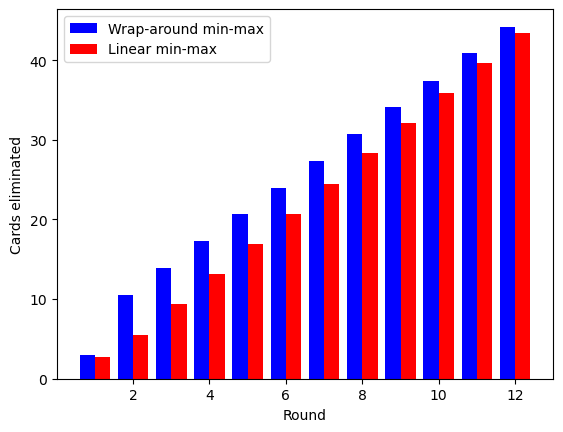

In [9]:
# Plot comparison of cards eliminated by round
rounds = np.arange(1, HAND_SIZE)
bar_width = 0.4
r1 = rounds - bar_width / 2
r2 = rounds + bar_width / 2

plt.bar(r1, expected_cards_eliminated_wrap, width=bar_width, color='b', label='Wrap-around min-max')
plt.bar(r2, expected_cards_eliminated_linear, width=bar_width, color='r', label='Linear min-max')
plt.xlabel('Round')
plt.ylabel('Cards eliminated')
plt.legend()
plt.savefig('cards_eliminated.png')
plt.show()

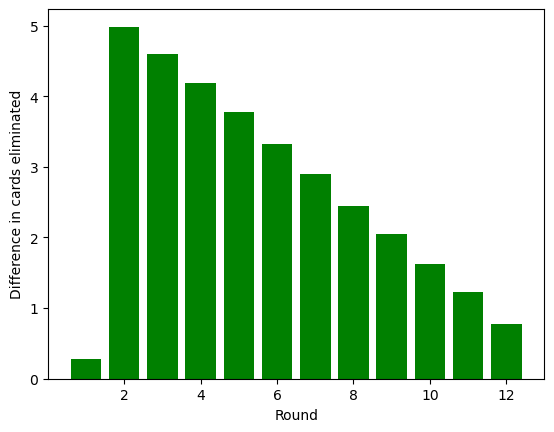

In [10]:
# Plot difference in cards eliminated by round
plt.bar(rounds, difference, color='g')
plt.xlabel('Round')
plt.ylabel('Difference in cards eliminated')
plt.savefig('difference.png')
plt.show()

In [11]:
# Simulations against each group, playing as NS
scores_wrap = [
    (85.84, 95.27),
    (85.32, 82.69),
    (85.61, 89.89),
    (88.91, 87.34),
    (85.72, 96.17),
    (85.83, 92.08),
    (85.11, 88.39),
    (89.17, 88.27),
    (85.47, 94.64),
    (91.17, 91.38)
]

scores_linear = [
    (82.02, 95.04),
    (81.42, 83.29),
    (81.46, 89.61),
    (76.56, 85.19),
    (82.31, 96.81),
    (83.81, 93.40),
    (81.63, 87.13),
    (83.64, 86.53),
    (82.19, 95.18),
    (74.81, 74.33)
]

scores_no_guess_the_middle = [
    (85.04, 91.38),
    (84.52, 82.30),
    (84.77, 89.89),
    (86.51, 87.34),
    (84.97, 96.17),
    (85.31, 92.08),
    (84.51, 88.39),
    (87.86, 88.27),
    (84.44, 94.62),
    (89.30, 89.32)
]

scores_no_prior_rounds = [
    (88.57, 95.27),
    (88.30, 82.30),
    (88.28, 89.89),
    (90.86, 87.34),
    (88.65, 96.17),
    (88.47, 92.08),
    (87.95, 88.39),
    (91.08, 88.27),
    (88.06, 94.66),
    (92.48, 92.77)
]

scores_no_argmax = [
    (82.58, 95.27),
    (82.07, 83.14),
    (82.20, 89.89),
    (84.82, 87.34),
    (82.67, 96.17),
    (82.22, 92.08),
    (82.63, 88.39),
    (83.91, 88.27),
    (82.69, 94.58),
    (85.88, 86.09)
]

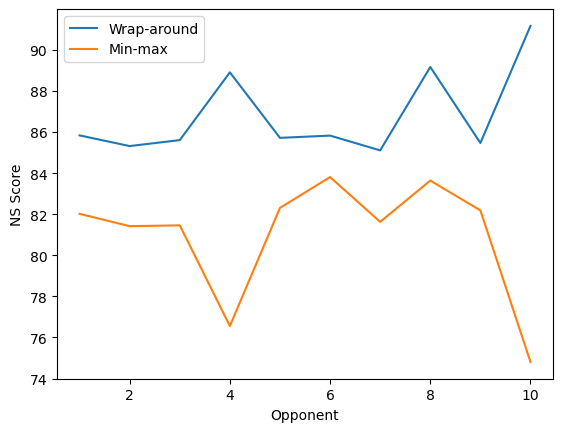

In [12]:
# Compare wrap-around and linear min-max
opponents = np.arange(1, 11)
plt.plot(opponents, [score[0] for score in scores_wrap], label='Wrap-around')
plt.plot(opponents, [score[0] for score in scores_linear], label='Min-max')
plt.xlabel('Opponent')
plt.ylabel('NS Score')
plt.legend()
plt.savefig('wrapablation.png')
plt.show()

In [13]:
# Average score differences
NS_scores_wrap = [score[0] for score in scores_wrap]
NS_scores_linear = [score[0] for score in scores_linear]
NS_scores_no_guess_from_middle = [score[0] for score in scores_no_guess_the_middle]
NS_scores_no_prior_cvals = [score[0] for score in scores_no_prior_rounds]
NS_scores_no_argmax = [score[0] for score in scores_no_argmax]

wrap_diff = np.array(NS_scores_wrap) - np.array(NS_scores_linear)
avg_wrap_diff = np.mean(difference)
median_wrap_diff = np.median(difference)
print(f'Average wrap diff: {avg_wrap_diff}, median: {median_wrap_diff}')

no_guess_diff = np.array(NS_scores_wrap) - np.array(NS_scores_no_guess_from_middle)
avg_no_guess_diff = np.mean(no_guess_diff)
median_no_guess_diff = np.median(no_guess_diff)
print(f'Average no guess diff: {avg_no_guess_diff}, median: {median_no_guess_diff}')

no_prior_diff = np.array(NS_scores_wrap) - np.array(NS_scores_no_prior_cvals)
avg_no_prior_diff = np.mean(no_prior_diff)
median_no_prior_diff = np.median(no_prior_diff)
print(f'Average no prior diff: {avg_no_prior_diff}, median: {median_no_prior_diff}')

no_argmax_diff = np.array(NS_scores_no_prior_cvals) - np.array(NS_scores_no_argmax)
avg_no_argmax_diff = np.mean(no_argmax_diff)
median_no_argmax_diff = np.median(no_argmax_diff)
print(f'Average no argmax diff: {avg_no_argmax_diff}, median: {median_no_argmax_diff}')

Average wrap diff: 2.6799916666666674, median: 2.6687499999999993
Average no guess diff: 1.0919999999999987, median: 0.8200000000000003
Average no prior diff: -2.455000000000001, median: -2.655000000000001
Average no argmax diff: 6.103000000000003, median: 6.060000000000002


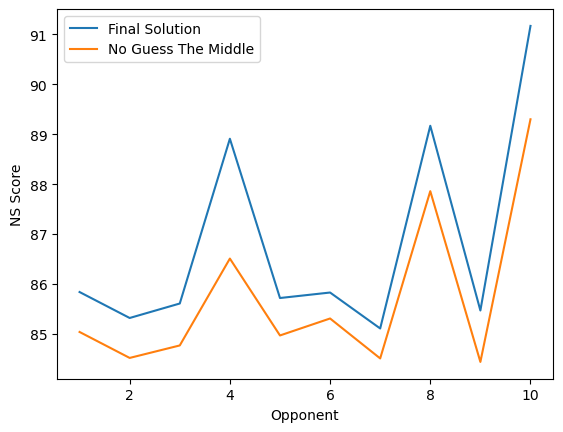

In [14]:
# Ablate guess from middle
opponents = np.arange(1, 11)
plt.plot(opponents, [score[0] for score in scores_wrap], label='Final Solution')
plt.plot(opponents, [score[0] for score in scores_no_guess_the_middle], label='No Guess The Middle')
plt.xlabel('Opponent')
plt.ylabel('NS Score')
plt.legend()
plt.savefig('noGuessTheMiddle.png')
plt.show()

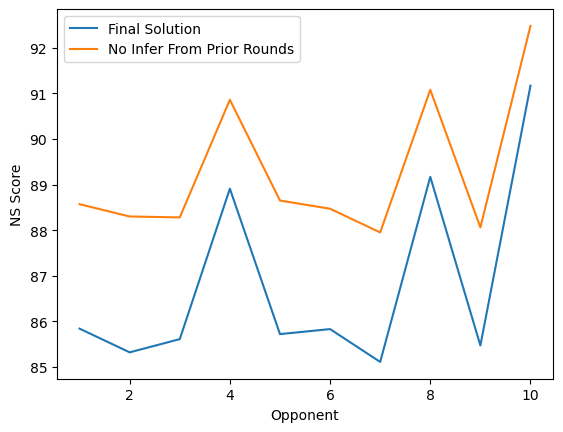

In [15]:
# Ablate prior cvals
opponents = np.arange(1, 11)
plt.plot(opponents, [score[0] for score in scores_wrap], label='Final Solution')
plt.plot(opponents, [score[0] for score in scores_no_prior_rounds], label='No Infer From Prior Rounds')
plt.xlabel('Opponent')
plt.ylabel('NS Score')
plt.legend()
plt.savefig('noPriorRounds.png')
plt.show()

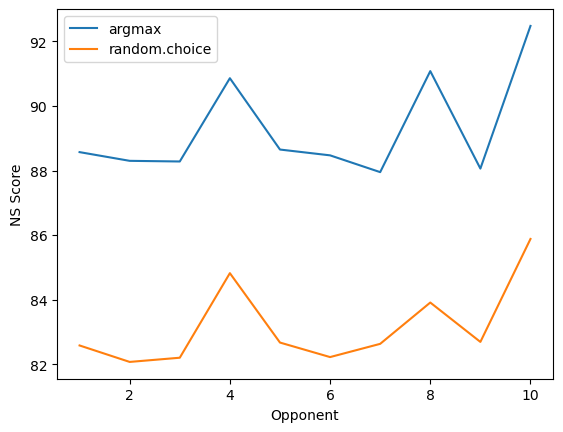

In [16]:
# Ablate argmax
opponents = np.arange(1, 11)
plt.plot(opponents, [score[0] for score in scores_no_prior_rounds], label='argmax')
plt.plot(opponents, [score[0] for score in scores_no_argmax], label='random.choice')
plt.xlabel('Opponent')
plt.ylabel('NS Score')
plt.legend()
plt.savefig('noArgmax.png')
plt.show()